In [1]:
!pip install opencv-python==4.5.5.64
!pip install opencv-contrib-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from google.colab.patches import cv2_imshow

from copy import deepcopy

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


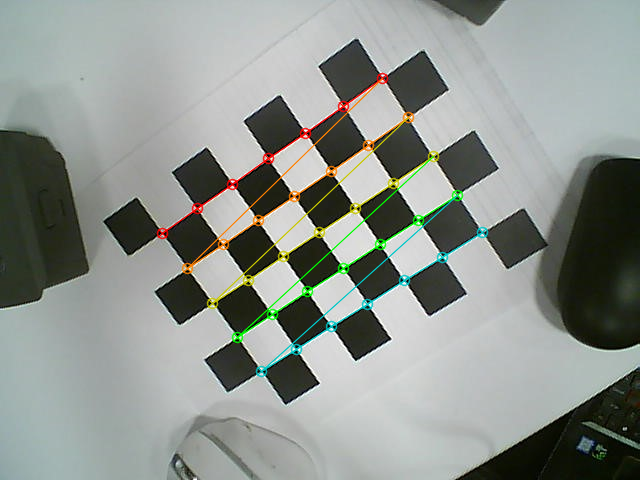

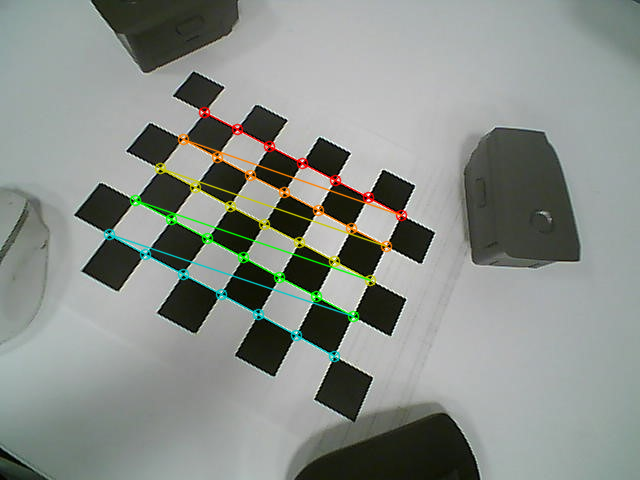

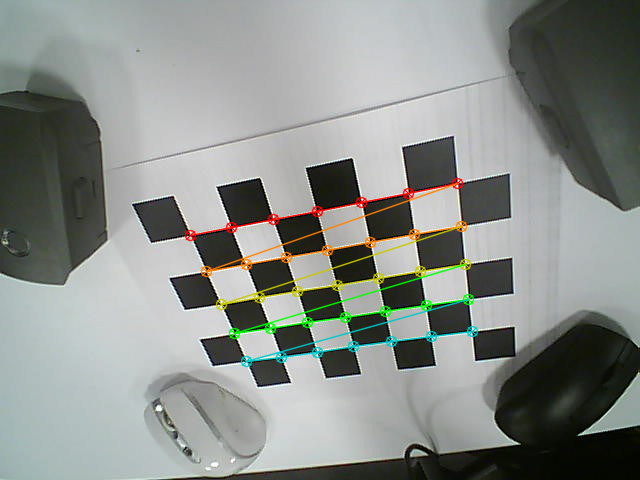

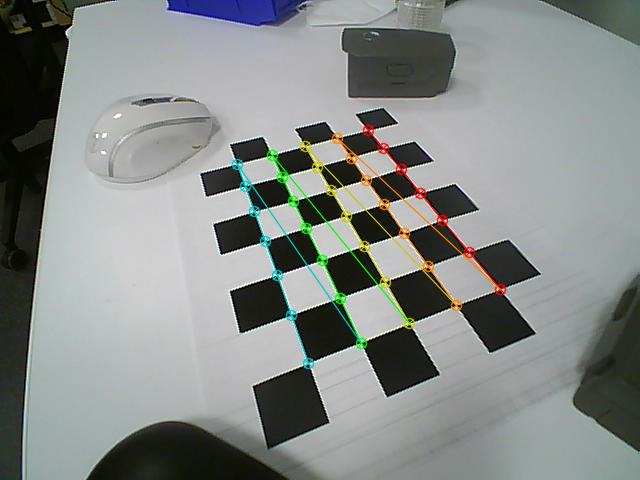

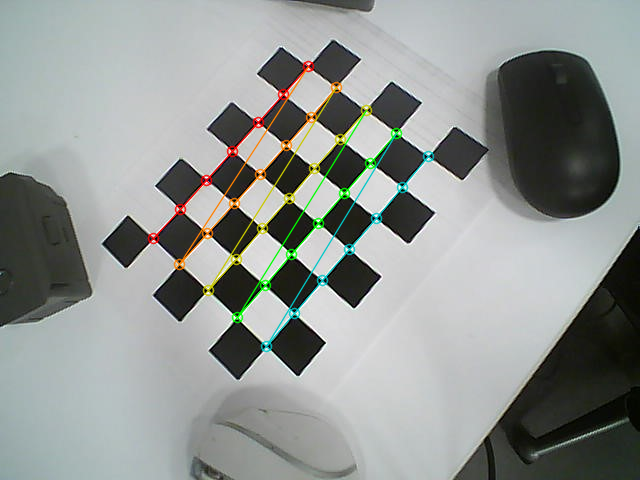

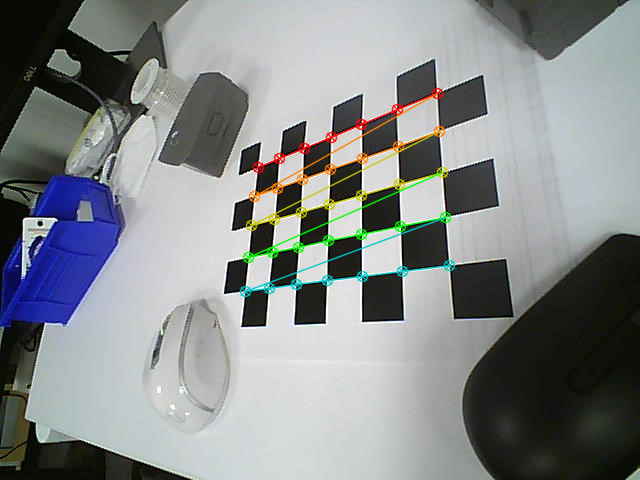

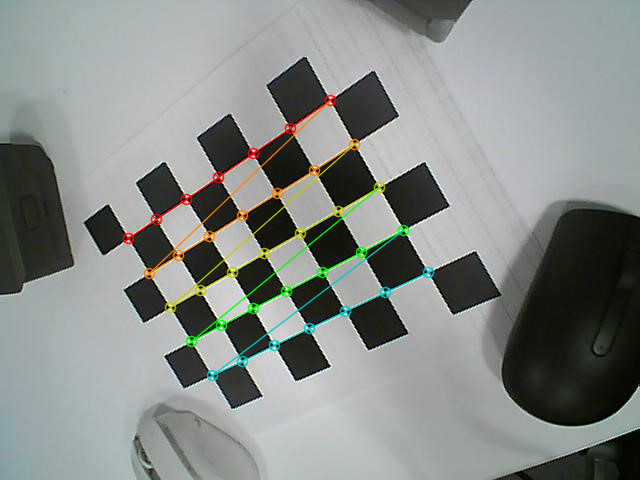

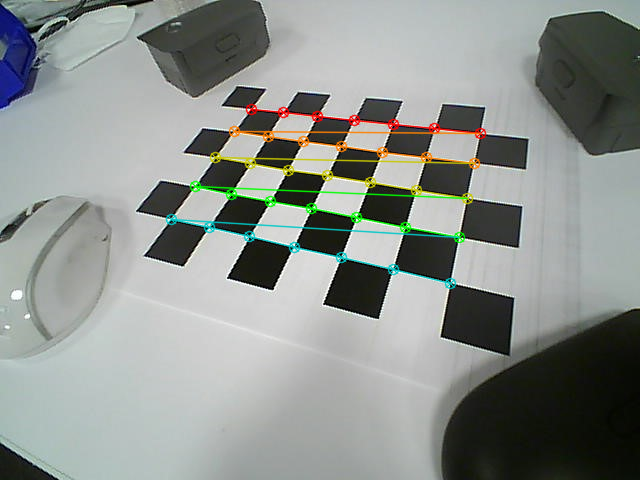

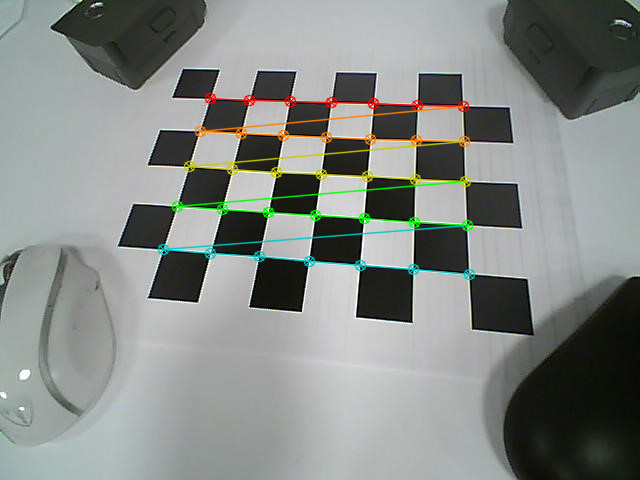

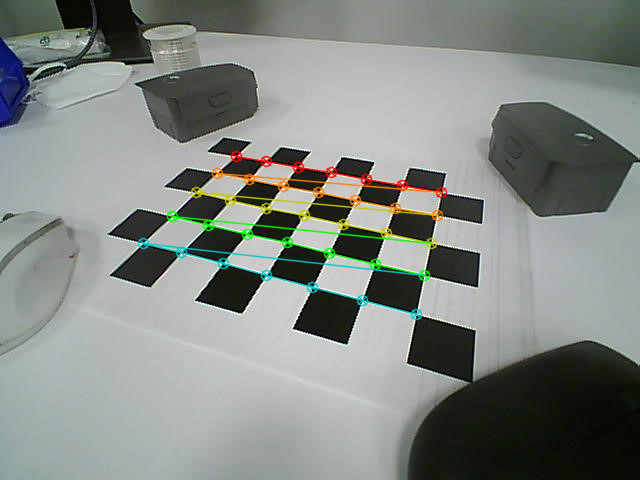

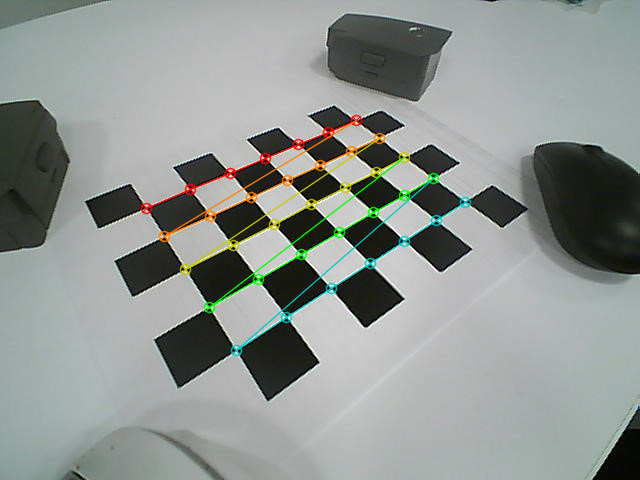

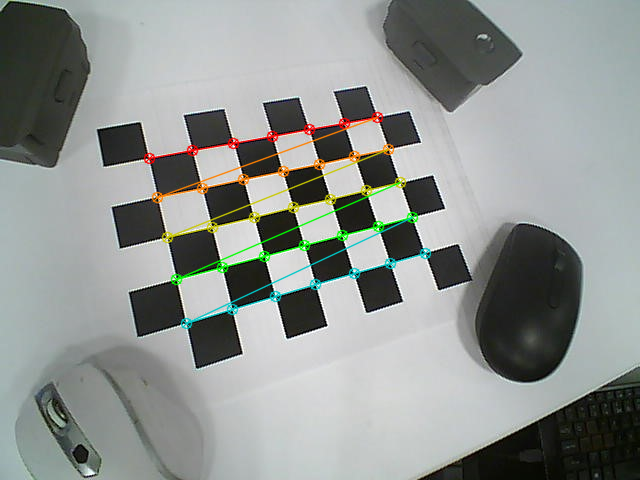

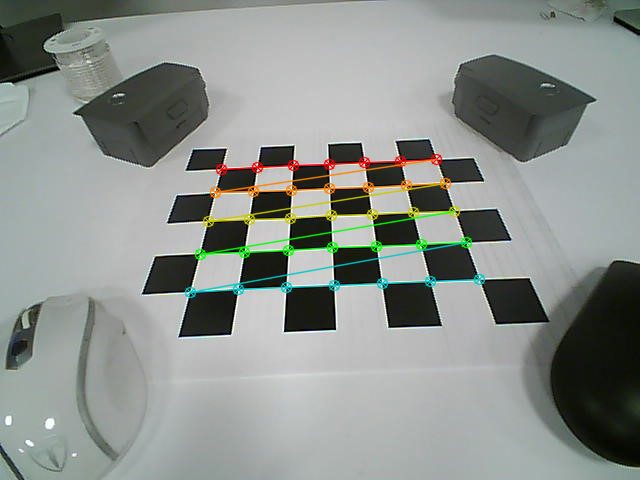

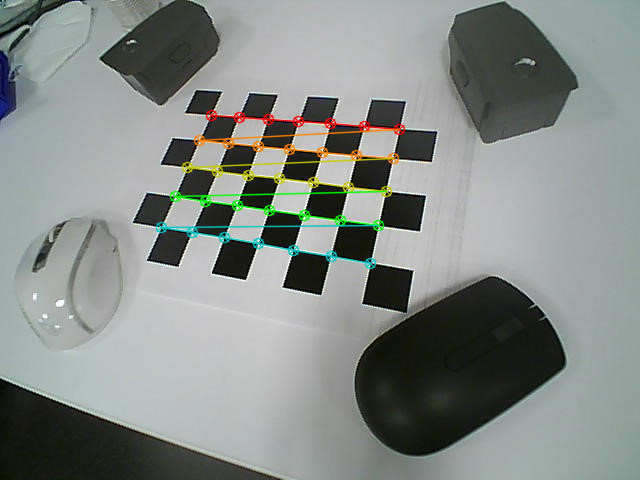

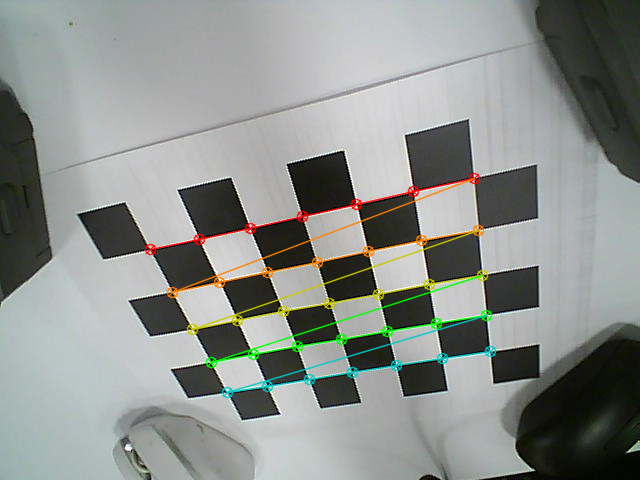

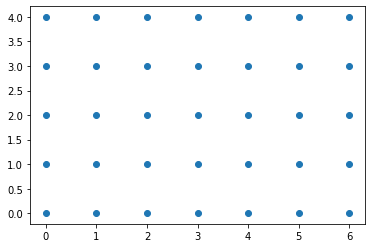

In [4]:
# Calibrate camera 
# Termination criteria

objp = np.zeros((5*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:5].T.reshape(-1,2)

plt.scatter(objp[:, 0], objp[:, 1]);

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# use images captured by camera in google drive
images = glob.glob("drive/MyDrive/A/test*")
for fname in images:
    img = cv2.imread(fname)
    
    # Resize to make sure the image does not contain too much pixels for Opencv to find patterns

    img = cv2.resize(img, (640,480))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners, we use 8*6 grid
    ret, corners = cv2.findChessboardCorners(gray, (7,5),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
      objpoints.append(objp)
      # cv2.cornerSubPix() increases the accuracy of the corner coordinates
      corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
      imgpoints.append(corners2)
      # Draw and display the corners
      img = cv2.drawChessboardCorners(img, (7,5), corners2,ret)
      cv2_imshow(img)

In [5]:
# cv2.calibrateCamera() returns the camera matrix, distortion coefficients, rotation vectors, and translation vectors
ret, K, distorC, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# print the values
print("K matrix:\n", K)
print("Distortion coeffients:\n", distorC)

K matrix:
 [[373.05087601   0.         329.368206  ]
 [  0.         372.05674473 229.61536078]
 [  0.           0.           1.        ]]
Distortion coeffients:
 [[ 0.05706186  0.20573628  0.00194242  0.00170834 -0.70899507]]


In [6]:
# Load measurment images in folder B
measure_img = glob.glob('drive/MyDrive/B/*') 
measure_img.sort()
M_imgs = []

In [ ]:
orb = cv2.ORB_create()

img1 = cv2.imread("box.jpg")

for fname in measure_img: 
  img2 = cv2.imread(fname)
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)

  img_kp1 = cv2.drawKeypoints(img1, kp1, None)
  img_kp2 = cv2.drawKeypoints(img2, kp2, None)

  # create BFMatcher object
  bf = cv2.BFMatcher()
  # Match descriptors.
  match = bf.knnMatch(des1,des2, k=2)

  good_match = []
  for m,n in match:
    if m.distance < .75 * n.distance:
      good_match.append([m])

  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_match, None, flags=2)

  print(fname)
  print("-> %d pairs of matches" % len(good_match))
  cv2_imshow(img3)
  add = cv2.imread(fname)
  M_imgs.append(add)


In [ ]:
imgs = M_imgs[:5] # images used for triangulations
for x in imgs:
  print(cv2_imshow(x))

In [ ]:
# coordinates for 0.jpg
coordinates_img = [[285, 108],
[293, 77],
[378, 80],
[385, 110],
[379, 163],
[289, 161],
[114, 146],
[155, 143],
[127, 162],
[211, 337],
[140, 280],
[194, 258],
[350, 240],
[393, 238]]


# coordinates for 3.jpg
coordinates_img1 = [[370, 125],
[486, 138],
[413, 108],
[441, 149],
[425, 210],
[361, 173],
[238, 105],
[257, 112],
[230, 114],
[124, 208],
[186, 177],
[154, 171],
[309, 240],
[339, 259]]


# coordinates for 5.jpg
coordinates_img2 = [[378, 80],
[425, 45],
[508, 86],
[463, 129],
[444, 174],
[370, 130],
[225, 66],
[249, 76],
[219, 85],
[150, 243],
[160, 180],
[198, 183],
[332, 231],
[368, 251]]


# coordinates for 8.jpg
coordinates_img3 = [[389, 161],
[430, 140],
[520, 167],
[485, 196],
[468, 253],
[382, 215],
[239, 154],
[263, 161],
[233, 166],
[132, 301],
[156, 245],
[199, 248],
[348, 305],
[392, 327]]

# coordinates for 9.jpg
coordinates_img4 = [[479, 141],
[547, 134],
[626, 186],
[551, 198],
[523, 257],
[460, 195],
[351, 105],
[365, 114],
[338, 113],
[209, 180],
[251, 154],
[275, 164],
[367, 251],
[390, 280]]

In [ ]:
all_coordinates = []  # list of list of coordinates
all_coordinates.append(np.asarray(coordinates_img)) 
all_coordinates.append(np.asarray(coordinates_img1))
all_coordinates.append(np.asarray(coordinates_img2))
all_coordinates.append(np.asarray(coordinates_img3))
all_coordinates.append(np.asarray(coordinates_img4))
print(all_coordinates)

In [ ]:
# Finding Aruco in each image...
ARUCO_DICT = {"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11}
arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT["DICT_APRILTAG_36h11"])
arucoParams = cv2.aruco.DetectorParameters_create()

In [ ]:
apriltag_img = cv2.imread("0.jpg")
cv2_imshow(apriltag_img[:,:,::-1]) # image before finding corners
image_points0, ids0, _ = cv2.aruco.detectMarkers(apriltag_img, arucoDict, parameters=arucoParams) # finding corners
all_coordinates[0] = np.concatenate((all_coordinates[0], image_points0[0][0])) # adding corner coordinates to respective arrays

if len(image_points0) > 0:
	# flatten the ArUco IDs list
	ids = ids0.flatten()
	# loop over the detected ArUCo corners
	for (markerCorner, markerID) in zip(image_points0, ids):
		# extract the marker corners
		image_points0 = markerCorner.reshape((4, 2))
		(topLeft, topRight, bottomRight, bottomLeft) = image_points0
		# convert each of the (x, y)-coordinate pairs to integers
		topRight = (int(topRight[0]), int(topRight[1]))
		bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
		bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
		topLeft = (int(topLeft[0]), int(topLeft[1]))
  
  # draw the bounding box of the ArUCo detection
cv2.line(apriltag_img, topLeft, topRight, (0, 255, 0), 4)
cv2.line(apriltag_img, topRight, bottomRight, (0, 255, 0), 4)
cv2.line(apriltag_img, bottomRight, bottomLeft, (0, 255, 0), 4)
cv2.line(apriltag_img, bottomLeft, topLeft, (0, 255, 0), 4)

for x in (all_coordinates[0]): # for all image's observed point coordinates
  cv2.circle(apriltag_img, (int(x[0]), int(x[1])), 3, (0, 255, 255),thickness=3) # highlight in yellow

cv2_imshow(apriltag_img) # new image


In [ ]:
apriltag_img1 = cv2.imread("3.jpg")
cv2_imshow(apriltag_img1[:,:,::-1])
image_points1, ids1, _ = cv2.aruco.detectMarkers(apriltag_img1, arucoDict, parameters=arucoParams)
all_coordinates[1] = np.concatenate((all_coordinates[1], image_points1[0][0]))

if len(image_points1) > 0:
	# flatten the ArUco IDs list
	ids = ids1.flatten()
	# loop over the detected ArUCo corners
	for (markerCorner, markerID) in zip(image_points1, ids):
		# extract the marker corners
		image_points1 = markerCorner.reshape((4, 2))
		(topLeft, topRight, bottomRight, bottomLeft) = image_points1
		# convert each of the (x, y)-coordinate pairs to integers
		topRight = (int(topRight[0]), int(topRight[1]))
		bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
		bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
		topLeft = (int(topLeft[0]), int(topLeft[1]))
  
  # draw the bounding box of the ArUCo detection
cv2.line(apriltag_img1, topLeft, topRight, (0, 255, 0), 4)
cv2.line(apriltag_img1, topRight, bottomRight, (0, 255, 0), 4)
cv2.line(apriltag_img1, bottomRight, bottomLeft, (0, 255, 0), 4)
cv2.line(apriltag_img1, bottomLeft, topLeft, (0, 255, 0), 4)

for x in (all_coordinates[1]):
  cv2.circle(apriltag_img1, (int(x[0]), int(x[1])), 3, (0, 255, 255),thickness=3)

cv2_imshow(apriltag_img1)

In [ ]:
apriltag_img2 = cv2.imread("5.jpg")
cv2_imshow(apriltag_img2[:,:,::-1])
image_points2, ids2, _ = cv2.aruco.detectMarkers(apriltag_img2, arucoDict, parameters=arucoParams)
all_coordinates[2] = np.concatenate((all_coordinates[2], image_points2[0][0]))

if len(image_points2) > 0:
	# flatten the ArUco IDs list
	ids = ids2.flatten()
	# loop over the detected ArUCo corners
	for (markerCorner, markerID) in zip(image_points2, ids):
		# extract the marker corners
		image_points2 = markerCorner.reshape((4, 2))
		(topLeft, topRight, bottomRight, bottomLeft) = image_points2
		# convert each of the (x, y)-coordinate pairs to integers
		topRight = (int(topRight[0]), int(topRight[1]))
		bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
		bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
		topLeft = (int(topLeft[0]), int(topLeft[1]))
  
  # draw the bounding box of the ArUCo detection
cv2.line(apriltag_img2, topLeft, topRight, (0, 255, 0), 4)
cv2.line(apriltag_img2, topRight, bottomRight, (0, 255, 0), 4)
cv2.line(apriltag_img2, bottomRight, bottomLeft, (0, 255, 0), 4)
cv2.line(apriltag_img2, bottomLeft, topLeft, (0, 255, 0), 4)

for x in (all_coordinates[2]):
  cv2.circle(apriltag_img2, (int(x[0]), int(x[1])), 3, (0, 255, 255),thickness=3)

cv2_imshow(apriltag_img2)

In [ ]:
apriltag_img3 = cv2.imread("8.jpg")
cv2_imshow(apriltag_img3[:,:,::-1])
image_points3, ids3, _ = cv2.aruco.detectMarkers(apriltag_img3, arucoDict, parameters=arucoParams)
all_coordinates[3] = np.concatenate((all_coordinates[3], image_points3[0][0]))

if len(image_points3) > 0:
	# flatten the ArUco IDs list
	ids = ids3.flatten()
	# loop over the detected ArUCo corners
	for (markerCorner, markerID) in zip(image_points3, ids):
		# extract the marker corners
		image_points3 = markerCorner.reshape((4, 2))
		(topLeft, topRight, bottomRight, bottomLeft) = image_points3
		# convert each of the (x, y)-coordinate pairs to integers
		topRight = (int(topRight[0]), int(topRight[1]))
		bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
		bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
		topLeft = (int(topLeft[0]), int(topLeft[1]))
  
  # draw the bounding box of the ArUCo detection
cv2.line(apriltag_img3, topLeft, topRight, (0, 255, 0), 4)
cv2.line(apriltag_img3, topRight, bottomRight, (0, 255, 0), 4)
cv2.line(apriltag_img3, bottomRight, bottomLeft, (0, 255, 0), 4)
cv2.line(apriltag_img3, bottomLeft, topLeft, (0, 255, 0), 4)

for x in (all_coordinates[3]):
  cv2.circle(apriltag_img3, (int(x[0]), int(x[1])), 3, (0, 255, 255),thickness=3)

cv2_imshow(apriltag_img3)

In [ ]:
apriltag_img4 = cv2.imread("9.jpg")
cv2_imshow(apriltag_img4[:,:,::-1])
image_points4, ids4, _ = cv2.aruco.detectMarkers(apriltag_img4, arucoDict, parameters=arucoParams)
all_coordinates[4] = np.concatenate((all_coordinates[4], image_points4[0][0]))

if len(image_points4) > 0:
	# flatten the ArUco IDs list
	ids = ids4.flatten()
	# loop over the detected ArUCo corners
	for (markerCorner, markerID) in zip(image_points4, ids):
		# extract the marker corners
		image_points4 = markerCorner.reshape((4, 2))
		(topLeft, topRight, bottomRight, bottomLeft) = image_points4
		# convert each of the (x, y)-coordinate pairs to integers
		topRight = (int(topRight[0]), int(topRight[1]))
		bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
		bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
		topLeft = (int(topLeft[0]), int(topLeft[1]))
  
  # draw the bounding box of the ArUCo detection
cv2.line(apriltag_img4, topLeft, topRight, (0, 255, 0), 4)
cv2.line(apriltag_img4, topRight, bottomRight, (0, 255, 0), 4)
cv2.line(apriltag_img4, bottomRight, bottomLeft, (0, 255, 0), 4)
cv2.line(apriltag_img4, bottomLeft, topLeft, (0, 255, 0), 4)

for x in (all_coordinates[4]):
  cv2.circle(apriltag_img4, (int(x[0]), int(x[1])), 3, (0, 255, 255),thickness=3)

cv2_imshow(apriltag_img4)

In [ ]:
print(all_coordinates)

In [ ]:
# Estimate essential matrix
E, mask = cv2.findEssentialMat(all_coordinates[0], all_coordinates[-1], K)

# Decompose essential matrix
RR1, RR2, t = cv2.decomposeEssentialMat(E)

In [ ]:
# Find the possible solution
projMatLeft = K @ np.concatenate((np.eye(3), np.zeros((3, 1))), axis=1)
projMatRight1 = K @ np.concatenate((RR1, t), axis=1)
projMatRight2 = K @ np.concatenate((RR1, -t), axis=1)
projMatRight3 = K @ np.concatenate((RR2, t), axis=1)
projMatRight4 = K @ np.concatenate((RR2, -t), axis=1)

# Triangulate points
X1 = cv2.triangulatePoints(projMatLeft, projMatRight1, all_coordinates[0].T, all_coordinates[-1].T)
X2 = cv2.triangulatePoints(projMatLeft, projMatRight2, all_coordinates[0].T, all_coordinates[-1].T)
X3 = cv2.triangulatePoints(projMatLeft, projMatRight3, all_coordinates[0].T, all_coordinates[-1].T)
X4 = cv2.triangulatePoints(projMatLeft, projMatRight4, all_coordinates[0].T, all_coordinates[-1].T)


X1 = X1 / X1[-1]
X2 = X2 / X2[-1]
X3 = X3 / X3[-1]
X4 = X4 / X4[-1]
print('z1:', X1[2])
print('z2:', X2[2])
print('z3:', X3[2])
print('z4:', X4[2])

In [ ]:
# Values in z4 are all positive. Therefore, we choose (RR2, -t) as the intial pose and X4 as the intial position for the object points.
rvec0, tvec0 = np.zeros(3), np.zeros(3) #3, 3
rvec4, tvec4 = cv2.Rodrigues(RR2)[0].ravel(), -t.ravel() #3, 3
X = X4[:3].T
# solve the poses for the other 3 cameras
rvecs = []
tvecs = []
for x in all_coordinates[1:-1]:
  ret, rvec, tvec = cv2.solvePnP(X, x, K, distorC)
  rvecs.append(rvec.ravel())
  tvecs.append(tvec.ravel())

rvecs = np.concatenate([rvec0] + rvecs + [rvec4])
tvecs = np.concatenate([tvec0] + tvecs + [tvec4])
params0 = np.concatenate([rvecs, tvecs, X.reshape(-1)]) 

In [ ]:
# Objective function
def fun(params, K, distorC, n_cams, all_coordinates):
  all_coordinates = np.concatenate(all_coordinates)
  rvecs = params[:3*n_cams]
  tvecs = params[3*n_cams:6*n_cams]
  X = params[6*n_cams:]
  x_hat = []
  for i in range(n_cams):
    rvec, tvec = rvecs[i*3:i*3+3], tvecs[i*3:i*3+3]
    x = cv2.projectPoints(X.reshape(-1, 3), rvec, tvec, K, distorC)[0]

    x_hat.append(x[:, 0, :])
    
  x_hat = np.concatenate(x_hat)

  # indexed array along dimension is 90
  mask = np.ones(90, dtype=bool)

  return (x_hat - all_coordinates)[mask].ravel()

plt.stem(fun(params0, K, distorC, 5, all_coordinates))
plt.ylim([-4, 4])

In [ ]:
# Optimization
res = least_squares(fun, params0, verbose=2, x_scale='jac', ftol=1e-8, method='trf', args=(K, distorC, 5, all_coordinates))
plt.stem(res.fun)
plt.ylim([-4, 4])
print(res.fun.min())
print(res.fun.max())

In [ ]:
# More optimization
X_o = res.x[30:].reshape(-1, 3)
x_corners = X_o[-4:]

In [ ]:
# Pixel to mm conversion
dist = np.linalg.norm(x_corners[[1, 2, 3, 0]] - x_corners[[0, 1, 2, 3]], axis=-1)
pixel_ratio = 150.1 / dist.mean()
print(pixel_ratio)

In [ ]:
# Solve for L, W, H

Length = np.linalg.norm(X[3] - X[0]) * pixel_ratio # ((Box top right corner) - (Box top left corner)) * pixel_to_mm ratio
Width = np.linalg.norm(X[2] - X[3]) * pixel_ratio # ((Box upper top right corner) - (Box top right corner)) * pixel_to_mm ratio
Height = np.linalg.norm(X[4] - X[3]) * pixel_ratio # ((Box bottom right corner) - (Box top right corner)) * pixel_to_mm ratio

print("Length: ", round(Length), " mm")
print("Width: ", round(Width), " mm")
print("Height: ", round(Height), " mm")